In [11]:
import pytorch_lightning as pl
from glob import glob
import torch
import os

from datasets.coil import Coil100Module
from modelling import CNN
from modelling.pretrained import linear_trained_on_coil_p1
from experiments.rejectron.rejectron import RejectronClassifier

from tqdm import tqdm
import matplotlib.pyplot as plt

os.chdir(f'/voyager/projects/tomginsberg/pqlearning')

In [12]:
checkpoints = sorted(
    glob('checkpoints/rejectron_coil_p1_lenet/c*/*ckpt'),
    # sort by model num in "checkpoints/rejectron_mnist/c_(model num)"
    key=lambda x: int(x.split('/')[2].split('_')[-1])
)
rejectors = [linear_trained_on_coil_p1().cuda(device=2)] + \
            [CNN.load_from_checkpoint(checkpoint_path=checkpoint).cuda(device=2) for checkpoint in tqdm(checkpoints)]

coil = Coil100Module(batch_size=250, split=1)

100%|██████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 50.15it/s]


In [13]:
y_true = []
y_pred = []
for x, y in tqdm(coil.test_dataloader()):
    x = x.cuda(device=2)
    y_true.append(y)
    y_pred.append(torch.stack([f(x).argmax(1).cpu() for f in rejectors]))

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred, dim=1)

  0%|                                                                        | 0/8 [00:00<?, ?it/s]/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.12it/s]


In [14]:
accs = []
rejs = []
y_true_tmp = y_true.clone()
mask = torch.ones_like(y_true, dtype=bool)
for pred in tqdm(y_pred):
    pred_m = pred[mask]
    true_m = y_true_tmp[mask]
    
    pred_mask = pred_m == true_m
    acc = (pred_mask).float().mean()
    rej = 1 - mask.float().mean()
    
    # update the mask
    if not mask.all():
        y_true_tmp[~mask] = -1
    mask = y_true_tmp == pred
    
    accs.append(acc)
    rejs.append(rej)

accs = torch.tensor(accs)
rejs = torch.tensor(rejs)

100%|████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 8176.77it/s]


In [15]:
# baseline, val set

y_true = []
y_pred = []
for x, y in tqdm(coil.val_dataloader()):
    x = x.cuda(device=2)
    y_true.append(y)
    y_pred.append(torch.stack([f(x).argmax(1).cpu() for f in rejectors]))

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred, dim=1)

100%|████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.17it/s]


In [16]:
accs_bs = []
rejs_bs = []
y_true_tmp = y_true.clone()
mask = torch.ones_like(y_true, dtype=bool)
for pred in tqdm(y_pred):
    pred_m = pred[mask]
    true_m = y_true_tmp[mask]
    
    pred_mask = pred_m == true_m
    acc = (pred_mask).float().mean()
    rej = 1 - mask.float().mean()
    
    # update the mask
    if not mask.all():
        y_true_tmp[~mask] = -1
    mask = y_true_tmp == pred
    
    accs_bs.append(acc)
    rejs_bs.append(rej)

accs_bs = torch.tensor(accs_bs)
rejs_bs = torch.tensor(rejs_bs)

100%|████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 5403.00it/s]


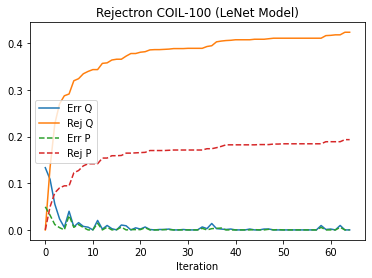

In [19]:
rng = range(len(accs))
plt.plot(rng, 1-accs, label='Err Q')
plt.plot(rng, rejs, label='Rej Q' )

plt.plot(rng, 1-accs_bs,'--', label='Err P')
plt.plot(rng, rejs_bs,'--', label='Rej P' )

plt.legend()
plt.title('Rejectron COIL-100 (LeNet Model)')
plt.xlabel('Iteration')
plt.savefig('notebooks/rejectron_coil_lenet.pdf')

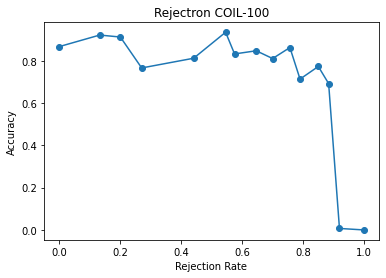

In [9]:
rng = range(len(accs))
plt.plot(rejs, accs, '-o')
plt.xlabel('Rejection Rate')
plt.ylabel('Accuracy')

# plt.legend()
plt.title('Rejectron COIL-100')
plt.savefig('rej-acc_coil.pdf')

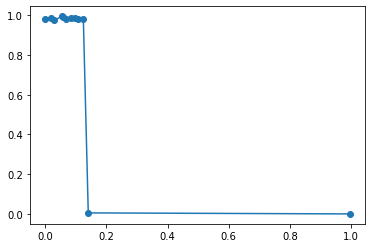

In [16]:
plt.plot(rejs_bs, accs_bs,'-o')

In [29]:
import numpy as np

In [18]:
h = rejectors[0]

In [38]:
outs = []
with torch.no_grad():
    for x, _ in tqdm(coil.test_dataloader()):
        x = x.cuda(device=2)
        outs.append((h(x)).cpu())
outs = torch.cat(outs)

100%|██████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.32it/s]


In [39]:
np.savetxt('notebooks/coil-test.txt', outs)

In [34]:
outs.shape

torch.Size([1800, 100])

In [44]:
testlabels = torch.cat([y for _, y in coil.test_dataloader()])

In [46]:
for x in testlabels:
    print(x.item(), end=', ')

87, 58, 72, 81, 24, 48, 38, 70, 30, 91, 19, 88, 24, 25, 62, 15, 1, 97, 50, 26, 67, 65, 55, 94, 95, 4, 81, 13, 31, 29, 32, 27, 53, 20, 92, 55, 89, 63, 62, 16, 83, 25, 55, 68, 1, 64, 28, 60, 90, 31, 31, 60, 43, 9, 56, 99, 21, 38, 69, 87, 61, 81, 8, 49, 86, 69, 66, 29, 30, 75, 29, 72, 24, 38, 27, 4, 12, 63, 38, 70, 30, 31, 11, 48, 55, 17, 15, 41, 36, 62, 64, 14, 99, 89, 9, 18, 85, 87, 47, 7, 39, 39, 41, 70, 47, 3, 6, 90, 69, 95, 21, 91, 63, 21, 51, 41, 36, 46, 62, 0, 89, 59, 15, 93, 44, 66, 21, 93, 80, 97, 65, 54, 42, 0, 11, 84, 18, 42, 4, 85, 14, 65, 42, 3, 25, 54, 58, 0, 94, 37, 77, 46, 58, 39, 49, 43, 32, 41, 62, 23, 71, 96, 68, 4, 48, 10, 69, 41, 77, 71, 96, 1, 30, 80, 39, 53, 77, 43, 39, 19, 9, 31, 51, 26, 96, 60, 35, 36, 9, 63, 92, 74, 11, 51, 41, 85, 6, 88, 91, 44, 22, 37, 81, 95, 87, 30, 33, 89, 18, 66, 80, 11, 71, 66, 48, 82, 29, 41, 54, 41, 13, 23, 73, 52, 85, 60, 62, 92, 69, 10, 40, 21, 52, 87, 31, 98, 14, 4, 99, 55, 19, 16, 57, 66, 96, 7, 12, 94, 11, 79, 80, 74, 6, 82, 74, 83,